In [1]:
import os
import sys
import yaml
import torch
import tqdm
import numpy as np
import matplotlib.pyplot as plt

base_dir = os.path.join(os.getcwd(), '..')
sys.path.append(base_dir)

import src.preprocessing as preproc
from src.models import *

In [2]:
# Load config file
with open('../config/ideal.yaml', "r") as f:
    cfg = yaml.safe_load(f)
cfg['dataset']['path'] = '../data/aodisaggregation_emmisions_test_6.3_ACCMIP_200806.06_echam.nc'

# Load dataset
data = preproc.make_data(cfg=cfg, include_2d=False)

In [3]:
# Choose a random subset of 1000 points to evaluate model over
torch.random.manual_seed(5)
rdm_idx = torch.randperm(len(data.h_by_column_std))[:1000]

# Predict idealized exponential height profile
lbda = cfg['model']['lbda']
h_stddev = data.h_by_column.std()
prediction_3d = torch.exp(-lbda * data.h_by_column_std[rdm_idx])

# Rescale predictions by τ/∫φdh
aggregate_prediction = h_stddev * (torch.exp(-lbda * data.h_by_column_std[:, -1]) - torch.exp(-lbda * data.h_by_column_std[:, 0])) / lbda
correction = data.z_smooth[rdm_idx] / aggregate_prediction[rdm_idx]
prediction_3d = prediction_3d.mul(correction.unsqueeze(-1))

In [4]:
# Compute calibration plots for given region sizes
def compute_calibrations(prediction_3d_dist, sizes):
    calibration = []
    mu = prediction_3d_dist.mean
    for size in sizes:
        q_lb = (1 - size) / 2
        q_ub = 1 - q_lb
        lb = prediction_3d_dist.icdf(torch.tensor(q_lb))
        ub = prediction_3d_dist.icdf(torch.tensor(q_ub))
        lb_mask = data.gt_by_column[rdm_idx] > lb
        ub_mask = data.gt_by_column[rdm_idx] < ub
        value_mask = data.gt_by_column[rdm_idx] > -1
        region_mask = lb_mask[value_mask] & ub_mask[value_mask]
        calibration.append(region_mask.float().mean().item())
    return np.asarray(calibration)

# Rescale distribution variance without shifting mean
def rescale_variance(prediction_3d, noise):
    prediction_3d_dist = torch.distributions.Normal(prediction_3d, noise)
    return prediction_3d_dist

# Compute deviation from perfect calibration
def calibration_integral(calibration, sizes):
    return np.abs(calibration - sizes).sum()

In [5]:
# Range of noises to look into
noises = np.geomspace(1e-8, 1e-4, 100)
noises_iter = tqdm.notebook.tqdm(noises)

# Confidence region sizes to consider
sizes = np.arange(0.01, 1., 0.01)

integrals = []
for noise in noises_iter:
    recalibrated_dist = rescale_variance(prediction_3d, noise)
    calibration = compute_calibrations(recalibrated_dist, sizes)
    integrals.append(calibration_integral(calibration, sizes))
integrals = np.asarray(integrals)

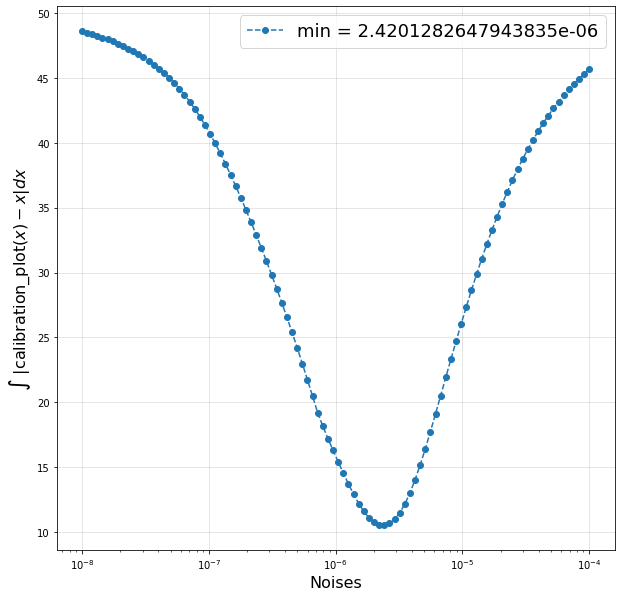

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

best_multiplier = noises[np.argmin(integrals)]
ax.plot(noises, integrals, '--o', label=f'min = {best_multiplier}')

ax.set_xlabel('Noises', fontsize=16)
ax.set_ylabel(r'$\int$ |calibration_plot$(x) - x|dx$ ', fontsize=16)
ax.grid(alpha=0.4)
ax.set_xscale('log')
plt.legend(fontsize=18)